In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [86]:
# Read the train and the test data 
train_users_orig = pd.read_csv('train_users_2.csv')
test_users = pd.read_csv('test_users.csv')


# Extracting labels from the train data
train_users_labels = train_users_orig.loc[:,'country_destination']
print (train_users_labels.head(n=5))

# Extracting attributes from the train data
train_users_attrs = train_users_orig.iloc[:,0:15]
print(train_users_attrs.head(n=5))

train_users = train_users_attrs

0      NDF
1      NDF
2       US
3    other
4       US
Name: country_destination, dtype: object
           id date_account_created  timestamp_first_active date_first_booking  \
0  gxn3p5htnn           2010-06-28          20090319043255                NaN   
1  820tgsjxq7           2011-05-25          20090523174809                NaN   
2  4ft3gnwmtx           2010-09-28          20090609231247         2010-08-02   
3  bjjt8pjhuk           2011-12-05          20091031060129         2012-09-08   
4  87mebub9p4           2010-09-14          20091208061105         2010-02-18   

      gender  age signup_method  signup_flow language affiliate_channel  \
0  -unknown-  NaN      facebook            0       en            direct   
1       MALE   38      facebook            0       en               seo   
2     FEMALE   56         basic            3       en            direct   
3     FEMALE   42      facebook            0       en            direct   
4  -unknown-   41         basic           

In [87]:
train_users = train_users.drop(['date_first_booking'], axis=1)
test_users = test_users.drop(['date_first_booking'], axis=1)

In [88]:
# Date is split into 3 parts as year, month and day in both test and train. These are added as
# new features in both test and train

date_acc_created = np.vstack(train_users.date_account_created.astype(str).apply(
        lambda x: list(map(int, x.split('-')))).values)
train_users['created_year'] = date_acc_created[:,0]
train_users['created_month'] = date_acc_created[:,1]
train_users['created_day'] = date_acc_created[:,2]
train_users = train_users.drop(['date_account_created'], axis=1)

date_acc_created_test = np.vstack(test_users.date_account_created.astype(str).apply(
        lambda x: list(map(int, x.split('-')))).values)
test_users['created_year'] = date_acc_created_test[:,0]
test_users['created_month'] = date_acc_created_test[:,1]
test_users['created_day'] = date_acc_created_test[:,2]
test_users = test_users.drop(['date_account_created'], axis=1)

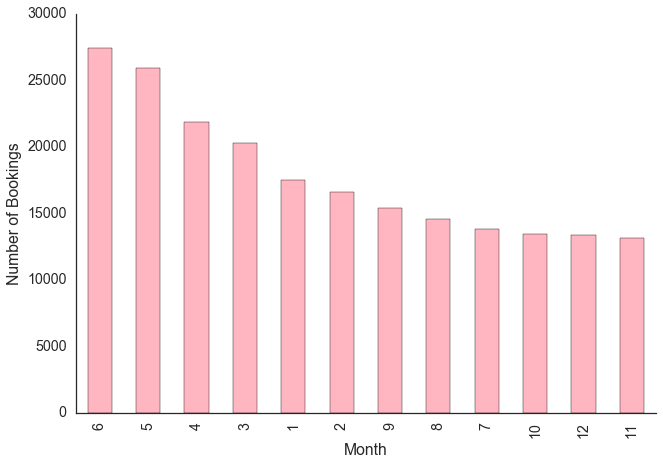

In [90]:
# There's more activity during the months 3-6
import seaborn as sbrn
sbrn.set_style("white")
sbrn.set_context("talk", font_scale=1.1)
#sbrn.set(color_codes=True)
month_distr = train_users.created_month.value_counts()
plt.xlabel('Month')
plt.ylabel('Number of Bookings')
month_distr.plot(kind='bar', color='#FFB6C1')
sbrn.despine()

In [35]:
# Replacing unknown values in gender with -1 and null values with -1
train_users.loc[ train_users['gender'] == '-unknown-', 'gender'] = -1
train_users.loc[ train_users['gender'].isnull(), 'gender' ] = -1
test_users.loc[ test_users['gender'] == '-unknown-', 'gender'] = -1
test_users.loc[ test_users['gender'].isnull(), 'gender'] = -1

In [36]:
# Encoding Female with 0, Male with 1 and Other with 2 in both test and train data
gender_translation = {'FEMALE' : 0,
                     'MALE' : 1,
                     'OTHER' : 2,
                     -1 : -1 }
for data in [train_users, test_users]:
    data['gender'] = data['gender'].apply(lambda x: gender_translation[x])

In [37]:
# Finding valid values for gender and invalid values for gender
nan_gender_count = len(train_users.loc[train_users['gender'] == -1, 'gender'])
valid_gender_count = len(train_users.gender.values) - nan_gender_count

# Creating a map with the gender distribution
count_map = pd.value_counts(train_users['gender'].values)
print ("Existing gender value distribution")
for k, v in count_map.iteritems():
    if k == -1:
        continue
    print (k, ":", float(v)/float(valid_gender_count))

Existing gender value distribution
0 : 0.5353209412124351
1 : 0.46228441870536585
2 : 0.002394640082198993


In [38]:
# Making the gender distribution the same for missing imputation
for k, v in count_map.iteritems():
    if k == -1:
        continue
    c = int ( nan_gender_count * float(v)/float(valid_gender_count) )
    for i in range(len(train_users.gender.values)):
        if train_users.gender.values[i] == -1:
            train_users.gender.values[i] = k
            c -= 1
        if c == 0:
            break
train_users.gender.values[213450] = 0

In [39]:
train_users.gender.describe()

count    213451.000000
mean          0.467072
std           0.503691
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           2.000000
Name: gender, dtype: float64

In [40]:
nan_gender_count = len(test_users.loc[test_users['gender'] == -1, 'gender'])
valid_gender_count = len(test_users.gender.values) - nan_gender_count
count_map = pd.value_counts(test_users['gender'].values)
print ("Existing gender value distribution")
for k, v in count_map.iteritems():
    if k == -1:
        continue
    print (k, ":", float(v)/float(valid_gender_count))

for k, v in count_map.iteritems():
    if k == -1:
        continue
    c = int ( nan_gender_count * float(v)/float(valid_gender_count) )
    for i in range(len(test_users.gender.values)):
        if test_users.gender.values[i] == -1:
            test_users.gender.values[i] = k
            c -= 1
        if c == 0:
            break
test_users.gender.values[62094] = 0

Existing gender value distribution
0 : 0.5116944601469757
1 : 0.486468343697004
2 : 0.0018371961560203504


In [41]:
train_users['age'].describe()

count    125461.000000
mean         49.668335
std         155.666612
min           1.000000
25%          28.000000
50%          34.000000
75%          43.000000
max        2014.000000
Name: age, dtype: float64

In [42]:
# Replacing invalid age with NaN in test and train

train_users.loc[train_users['age'] > 95, 'age'] = np.nan
train_users.loc[train_users['age'] < 16, 'age'] = np.nan
test_users.loc[test_users['age'] > 95, 'age'] = np.nan
test_users.loc[test_users['age'] < 16, 'age'] = np.nan

In [43]:
# Replace missing age with median
print (train_users.age.mean())
print (test_users.age.mean())
train_users.loc[ train_users['age'].isnull(), 'age' ] = train_users.age.mean()
test_users.loc[ test_users['age'].isnull(), 'age' ] = test_users.age.mean()

36.514069844987716
34.1409398015704


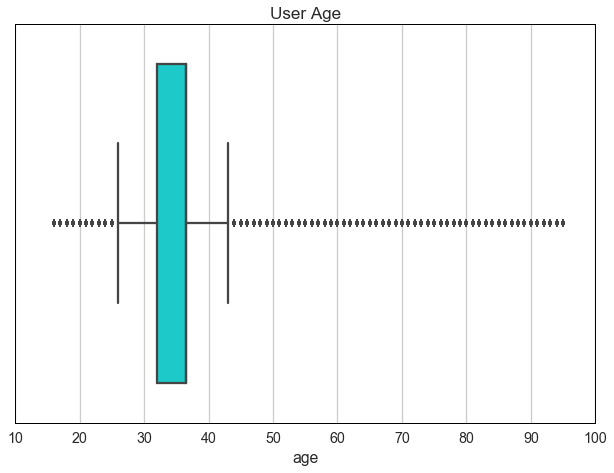

In [46]:
# Uer Age looks cleaned up now
sbrn.set_context("talk", font_scale=1.1)
sbrn.set_style("whitegrid", {'axes.edgecolor': '0'})
plt.title("User Age")
ax = sbrn.boxplot(x=train_users["age"], color='#00e6e6')

In [47]:
# Encoding the signup method for test
signup_translation = {'facebook' : 0,
                     'google' : 1,
                     'basic' : 2,
                     'weibo' : 3}
for data in [train_users, test_users]:
    data['signup_method'] = data['signup_method'].apply(lambda x: signup_translation[x])

In [48]:
# Encoding the language in both train and test
test_users.loc[ test_users['language'] == '-unknown-', 'language'] = "en"

In [49]:
language_encoding = {'en'      :       1       ,
'zh'      :       2       ,
'fr'      :       3       ,
'es'      :       4       ,
'ko'      :       5       ,
'de'      :       6       ,
'it'      :       7       ,
'ru'      :       8       ,
'pt'      :       9       ,
'ja'      :       10      ,
'sv'      :       11      ,
'nl'      :       12      ,
'tr'      :       13      ,
'da'      :       14      ,
'pl'      :       15      ,
'cs'      :       16      ,
'no'      :       17      ,
'el'      :       18      ,
'th'      :       19      ,
'id'      :       20      ,
'hu'      :       21      ,
'fi'      :       22      ,
'ca'      :       23      ,
'is'      :       24      ,
'hr'      :       25}

for data in [train_users, test_users]:
    data['language'] = data['language'].apply(lambda x: language_encoding[x])


In [50]:
affiliate_channel_encoding = {'direct' : 1,
                             'sem-brand' : 2,
                             'sem-non-brand' : 3,
                             'other' : 4,
                             'api' : 5,
                             'seo' : 6,
                             'content' : 7,
                             'remarketing' : 8}
for data in [train_users, test_users]:
    data['affiliate_channel'] = data['affiliate_channel'].apply(lambda x: affiliate_channel_encoding[x])

In [51]:
affiliate_provider_encoding = {'direct':1,
'google':2,
'other':3,
'craigslist':4,
'bing':5,
'facebook':6,
'vast':7,
'padmapper':8,
'facebook-open-graph':9,
'yahoo':10,
'gsp':11,
'meetup':12,
'email-marketing':13,
'naver':14,
'baidu':15,
'yandex':16,
'wayn':17,
'daum':18}

for data in [train_users, test_users]:
    data['affiliate_provider'] = data['affiliate_provider'].apply(lambda x: affiliate_provider_encoding[x])


In [52]:
train_users.loc[ train_users['first_affiliate_tracked'].isnull(), 'first_affiliate_tracked'] = "untracked"
test_users.loc[ test_users['first_affiliate_tracked'].isnull(), 'first_affiliate_tracked'] = "untracked"
first_affiliate_tracked_encoding = {'untracked' : 1,
                                   'linked' : 2,
                                   'omg' : 3,
                                   'tracked-other' : 4,
                                   'product' : 5,
                                   'marketing' : 6,
                                   'local ops' : 7}
for data in [train_users, test_users]:
    data['first_affiliate_tracked'] = data['first_affiliate_tracked'].apply(lambda x: first_affiliate_tracked_encoding[x])


In [53]:
signup_app_encoding = {'Web' : 1,
                      'iOS' : 2,
                      'Android' : 3,
                      'Moweb' : 4}
for data in [train_users, test_users]:
    data['signup_app'] = data['signup_app'].apply(lambda x: signup_app_encoding[x])


In [54]:
first_device_type_encoding = { 'Mac Desktop' : 1,
                             'iPhone' : 2,
                             'Windows Desktop' : 3,
                             'Android Phone' : 4,
                             'iPad' : 5,
                             'Android Tablet' : 6,
                             'Other/Unknown' : 7,
                             'Desktop (Other)' : 8,
                             'SmartPhone (Other)' : 9}
for data in [train_users, test_users]:
    data['first_device_type'] = data['first_device_type'].apply(lambda x: first_device_type_encoding[x])

In [55]:
first_browser_encoding = {'Chrome':1,
'Safari':2,
'Firefox':3,
'-unknown-':4,
'IE':5,
'Mobile Safari':6,
'Chrome Mobile':7,
'Android Browser':8,
'AOL Explorer':9,
'Opera':10,
'Silk':11,
'Chromium':12,
'BlackBerry Browser':13,
'Maxthon':14,
'IE Mobile':15,
'Apple Mail':16,
'Sogou Explorer':17,
'Mobile Firefox':18,
'RockMelt':19,
'SiteKiosk':20,
'Iron':21,
'IceWeasel':22,
'Pale Moon':23,
'SeaMonkey':24,
'Yandex.Browser':25,
'CometBird':26,
'Camino':27,
'TenFourFox':28,
'wOSBrowser':29,
'CoolNovo':30,
'Avant Browser':31,
'Opera Mini':32,
'Mozilla':33,
'Comodo Dragon':34,
'TheWorld Browser':35,
'Crazy Browser':36,
'Flock':37,
'OmniWeb':38,
'SlimBrowser':39,
'Opera Mobile':40,
'Conkeror':41,
'Outlook 2007':42,
'Palm Pre web browser':43,
'Stainless':44,
'NetNewsWire':45,
'Kindle Browser':46,
'Epic':47,
'Googlebot':48,
'Arora':49,
'Google Earth':50,
'IceDragon':51,
'PS Vita browser':52,
'IBrowse' : 53,
'UC Browser' : 54,
'IBrowse': 55,
'Nintendo Browser' : 56}


for data in [train_users, test_users]:
    data['first_browser'] = data['first_browser'].apply(lambda x: first_browser_encoding[x])

In [59]:
sessions = pd.read_csv('sessions.csv')

In [60]:
# frequency of each user_id in sessions data
df = sessions['user_id'].value_counts()
print (df.shape)
print (df)


(135483,)
mxqbh3ykxl    2722
0hjoc5q8nf    2644
mjbl6rrj52    2476
l5lgm3w5pc    2424
wg9413iaux    2362
ht8alhs4lt    2335
wyv1imf8qw    2323
9z4gim1s4l    2264
monrpvx2md    2264
h0cjxc177k    2246
a0uhiojrra    2137
vcmr2jh5ix    2085
1m6xnhstmb    2019
p1183hxzc4    1938
e8h4qghxlg    1923
gey51ednme    1919
5vpuk5mssg    1876
j2cvctvqve    1861
yu5bdalz2b    1811
ejpe95pcyo    1797
r541x78s24    1792
qkbkunyzq7    1780
n4s6g3grzf    1779
bfiueza7rt    1753
b1io359wpg    1752
8ikl7vnfa3    1732
e81qfos71y    1701
s5ez13snz0    1685
93dulcecw0    1614
r0rgjqbsvp    1612
              ... 
mec2cs3cra       1
i49rsz60rq       1
9k7bgqr6r9       1
ik1wxk26wo       1
zi2a11a999       1
9w94dnnpsi       1
yy92qrdvvu       1
tse5tmsk5q       1
ppeo5lb3y7       1
mdorengqr2       1
3z9sejcunx       1
uq4k9syl5f       1
fx1hmo045d       1
258mc4j11s       1
rboft8asrb       1
nwdx03kjix       1
8kfiy6ofhc       1
jdsj3qiu7t       1
hdlaamqy9v       1
9bjx1squch       1
a1ugu34vtv       1
3s

In [62]:
session_count_df = sessions.groupby(["user_id"])["user_id"].count().reset_index(name="session_count")
#print(session_count_df.sort('session_count'))

In [63]:
session_count_df=session_count_df.rename(columns = {'user_id':'id'})
train_users= pd.merge(train_users, session_count_df, on='id', how='left')
test_users = pd.merge(test_users, session_count_df, on='id', how='left')
#print(test_data_2)

In [64]:
train_users['session_count'].fillna(0, inplace=True)
test_users['session_count'].fillna(0, inplace=True)
#print(train_data_2)

In [65]:
print(train_users.shape)
print(test_users.shape)

(213451, 17)
(62096, 17)


In [66]:
train_user_wo_merge_wo_scale = train_users
test_user_wo_merge_wo_scale = test_users

#train_user_wo_merge_wo_scale.to_csv('train_users_wo_merge_wo_scale.csv',index=False)
#test_user_wo_merge_wo_scale.to_csv('test_users_wo_merge_wo_scale.csv',index=False)

In [67]:
# Get the total amount of time spent by each user browsing/booking 
secs = sessions.groupby(['user_id'])['secs_elapsed'].sum().reset_index()
secs.columns = ['user_id','secs_elapsed']

#print(secs.shape)

In [68]:
# Of the statistics, action_type and device_type have smaller number of unique values. Use these two attributes to 
# generate more columns and flatten the data in sessions so that each user has one row

# For each action_type (there are 10 of them, without NaN), make a column. Make each user_id the index. Fill in the values 
# of this dataframe with action value counts.

ac_types = pd.pivot_table(sessions, index = ['user_id'],columns = ['action_type'],
                             values = 'action',aggfunc=len,fill_value=0).reset_index()


In [69]:
# Similarly, for each device_type :

dev_type = pd.pivot_table(sessions, index = ['user_id'],columns = ['device_type'],
                          values = 'action',aggfunc=len,fill_value=0).reset_index()

In [70]:
sessions_merged = pd.merge(ac_types, dev_type, on='user_id', how='inner')
sessions_merged = pd.merge(sessions_merged, secs, on='user_id', how='inner')

# merge session_merged to train and test data
sessions_merged=sessions_merged.rename(columns = {'user_id':'id'})
train_users_merge = pd.merge(train_users, sessions_merged, on='id', how='left')
test_users_merge = pd.merge(test_users, sessions_merged, on='id', how='left')

train_users_merge.fillna(-1, inplace=True)
test_users_merge.fillna(-1, inplace=True)

print (train_users.shape)
print (test_users.shape)
print(train_users_merge.shape)
print(test_users_merge.shape)
train_users_merge_wo_scale = train_users_merge
test_users_merge_wo_scale = test_users_merge

(213451, 17)
(62096, 17)
(213451, 42)
(62096, 42)


In [71]:
train_users_merge.head()

,id,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,...,Linux Desktop,Mac Desktop,Opera Phone,Tablet,Windows Desktop,Windows Phone,iPad Tablet,iPhone,iPodtouch,secs_elapsed
0,gxn3p5htnn,20090319043255,0,36.51407,0,0,1,1,1,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,820tgsjxq7,20090523174809,1,38.00000,0,0,1,6,2,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,4ft3gnwmtx,20090609231247,0,56.00000,2,3,1,1,1,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,bjjt8pjhuk,20091031060129,0,42.00000,0,0,1,1,1,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,87mebub9p4,20091208061105,0,41.00000,2,0,1,1,1,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [72]:
country_destination_encoding = {'NDF': 0,
'US' : 1,
'other' : 2,
'FR' : 3,
'IT' : 4,
'GB' : 5,
'ES' : 6,
'CA' : 7,
'DE' : 8,
'NL' : 9,
'AU' : 10,
'PT' : 11}

# Convert series to frame
labels_df = train_users_labels.to_frame()

for data in [labels_df]:
    data['country_destination'] = data['country_destination'].apply(lambda x: country_destination_encoding[x])

    
    

In [73]:
print (train_users.shape)
train_users=train_users.drop(['id'], axis=1)
train_users_merge=train_users_merge.drop(['id'], axis=1)
#train_users.drop(train_users.columns[[1, 69]], axis=1, inplace=True)
print (train_users.head(n=5))
print (train_users.shape)


(213451, 17)
   timestamp_first_active  gender       age  signup_method  signup_flow  \
0          20090319043255       0  36.51407              0            0   
1          20090523174809       1  38.00000              0            0   
2          20090609231247       0  56.00000              2            3   
3          20091031060129       0  42.00000              0            0   
4          20091208061105       0  41.00000              2            0   

   language  affiliate_channel  affiliate_provider  first_affiliate_tracked  \
0         1                  1                   1                        1   
1         1                  6                   2                        1   
2         1                  1                   1                        1   
3         1                  1                   1                        1   
4         1                  1                   1                        1   

   signup_app  first_device_type  first_browser  created_year

In [74]:
from sklearn import preprocessing

stdscaler = preprocessing.StandardScaler()
train_users_scaled = stdscaler.fit_transform(train_users.values);
train_users = pd.DataFrame(train_users_scaled, columns = train_users.columns)

train_users_merge_scaled = stdscaler.fit_transform(train_users_merge.values);
train_users_merge = pd.DataFrame(train_users_merge_scaled, columns = train_users_merge.columns)

#test_users_scaled = stdscaler.fit_transform(test_users.values);
#test_users = pd.DataFrame(test_users_scaled, columns = test_users.columns)



In [75]:
train_users['country_destination'] = labels_df
print(train_users.head())

   timestamp_first_active    gender       age  signup_method  signup_flow  \
0               -4.380020 -0.927300  0.000000      -1.596552    -0.427798   
1               -4.357961  1.058047  0.169202      -1.596552    -0.427798   
2               -4.348661 -0.927300  2.218855       0.628333    -0.035009   
3               -4.303076 -0.927300  0.624681      -1.596552    -0.427798   
4               -4.283949 -0.927300  0.510811       0.628333    -0.427798   

   language  affiliate_channel  affiliate_provider  first_affiliate_tracked  \
0 -0.141579          -0.582242           -0.468760                -0.798954   
1 -0.141579           2.556797            0.251719                -0.798954   
2 -0.141579          -0.582242           -0.468760                -0.798954   
3 -0.141579          -0.582242           -0.468760                -0.798954   
4 -0.141579          -0.582242           -0.468760                -0.798954   

   signup_app  first_device_type  first_browser  created_year 

In [76]:
train_users_merge['country_destination'] = labels_df
print(train_users_merge.head())

   timestamp_first_active    gender       age  signup_method  signup_flow  \
0               -4.380020 -0.927300  0.000000      -1.596552    -0.427798   
1               -4.357961  1.058047  0.169202      -1.596552    -0.427798   
2               -4.348661 -0.927300  2.218855       0.628333    -0.035009   
3               -4.303076 -0.927300  0.624681      -1.596552    -0.427798   
4               -4.283949 -0.927300  0.510811       0.628333    -0.427798   

   language  affiliate_channel  affiliate_provider  first_affiliate_tracked  \
0 -0.141579          -0.582242           -0.468760                -0.798954   
1 -0.141579           2.556797            0.251719                -0.798954   
2 -0.141579          -0.582242           -0.468760                -0.798954   
3 -0.141579          -0.582242           -0.468760                -0.798954   
4 -0.141579          -0.582242           -0.468760                -0.798954   

   signup_app         ...           Mac Desktop  Opera Phone  

In [137]:
train_users.to_csv('train_users_wo_merge_scale.csv',index=False)
train_users_merge.to_csv('train_users_merge_scale.csv',index=False)

In [138]:
train_users_merge_wo_scale['country_destination'] = labels_df
train_users_merge_wo_scale.to_csv('train_users_merge_wo_scale.csv',index=False)
test_users_merge_wo_scale.to_csv('test_users_merge_wo_scale.csv',index=False)


In [140]:
train_user_wo_merge_wo_scale['country_destination'] = labels_df
train_user_wo_merge_wo_scale.to_csv('train_users_wo_merge_wo_scale.csv',index=False)
test_user_wo_merge_wo_scale.to_csv('test_users_wo_merge_wo_scale.csv',index=False)